In [51]:
import numpy as np
import pandas as pd
import os
import re
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader #, random_split
#from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import torchattacks
import shap

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

print("torchattacks %s"%(torchattacks.__version__))
pd.set_option('display.max_columns', 500)
shap.initjs()
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.deterministic = True
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

DRIAMS_B = 'DRIAMS-B'
DRIAMS_C = 'DRIAMS-C'
DRIAMS_D = 'DRIAMS-D'
datasets = [DRIAMS_B, DRIAMS_C, DRIAMS_D]
dataset = datasets[2]
organism = 'Klebsiella pneumoniae'
antimicrobials = ['Cefepime'] #, 'Tobramycin']
antimicrobial = antimicrobials[0]
batch_size = 128

# Leer datasets del origen
df = pd.read_csv(f'dataframes/dataframe_{dataset}_{organism}_{antimicrobial}.csv')
df_test = pd.read_csv('dataframes/test.csv')
df_test_driams = pd.read_csv(f'dataframes/dataframe_{DRIAMS_C}_{organism}_{antimicrobial}.csv')
df_test_gm = pd.read_csv('dataframes/gm_data.csv')
df_test_ryc = pd.read_csv('dataframes/ryc_data.csv')


def string_a_lista(cadena):
    cadena_sin_corchetes = re.sub(r'\[|\]', '', cadena)
    lista_de_floats = [float(x) for x in cadena_sin_corchetes.split(',')]
    return lista_de_floats

# Convertir cada string de la columna 'lista_strings' a una lista de floats
df['MALDI_binned'] = df['MALDI_binned'].apply(string_a_lista)

# GM + RyC en conjunto (lo utilizo para que la metrica a monitorizar en el sweep del wandb sea la auc conjunta de ambos datasets)
df_test['MALDI_binned'] = df_test['MALDI_binned'].apply(string_a_lista)
# DRIAMS TEST
df_test_driams['MALDI_binned'] = df_test_driams['MALDI_binned'].apply(string_a_lista)
# GM TEST
df_test_gm['MALDI_binned'] = df_test_gm['MALDI_binned'].apply(string_a_lista)
# RyC TEST
df_test_ryc['MALDI_binned'] = df_test_ryc['MALDI_binned'].apply(string_a_lista)

max_abs = df['MALDI_binned'].apply(max).max()
min_abs = df['MALDI_binned'].apply(min).min()

df['MALDI_binned'] = df['MALDI_binned'].apply(lambda x: [(val - min_abs) / (max_abs - min_abs) for val in x])
df_train, df_test_intrahospital = train_test_split(df, test_size=0.2, random_state=3, stratify = df[antimicrobial])

df_test['MALDI_binned'] = df_test['MALDI_binned'].apply(lambda x: [(val - min_abs) / (max_abs - min_abs) for val in x])
df_test_driams['MALDI_binned'] = df_test_driams['MALDI_binned'].apply(lambda x: [(val - min_abs) / (max_abs - min_abs) for val in x])
df_test_gm['MALDI_binned'] = df_test_gm['MALDI_binned'].apply(lambda x: [(val - min_abs) / (max_abs - min_abs) for val in x])
df_test_ryc['MALDI_binned'] = df_test_ryc['MALDI_binned'].apply(lambda x: [(val - min_abs) / (max_abs - min_abs) for val in x])

# Hago un shuffle de los conjuntos de test (por si acaso)
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test_driams = df_test_driams.sample(frac=1).reset_index(drop=True)
df_test_gm = df_test_gm.sample(frac=1).reset_index(drop=True)
df_test_ryc = df_test_ryc.sample(frac=1).reset_index(drop=True)

torchattacks 3.5.1


cuda:1


In [52]:
X = df_train.drop(antimicrobials, axis=1).values.tolist()
y = df_train[antimicrobial].values.astype('float32')

# Generación de tensores
tensor_X_train = torch.tensor(X, dtype=torch.float32)
tensor_X_train = tensor_X_train.view(tensor_X_train.shape[0], -1)

tensor_y_train = torch.tensor(y, dtype=torch.float32)

# INTRA-HOSPITAL

X_test_intrahospital = df_test_intrahospital['MALDI_binned'].values.tolist()

y_test_intrahospital = df_test_intrahospital[antimicrobial].values.astype('float32')

tensor_X_test_intrahospital = torch.tensor(X_test_intrahospital, dtype=torch.float32)
tensor_X_test_intrahospital = tensor_X_test_intrahospital.view(tensor_X_test_intrahospital.shape[0], -1)

tensor_y_test_intrahospital = torch.tensor(y_test_intrahospital, dtype=torch.float32)

dataset_intrahospital = TensorDataset(tensor_X_test_intrahospital, tensor_y_test_intrahospital)
testloader_intrahospital = DataLoader(dataset_intrahospital, batch_size=batch_size)

# DRIAMS
X_test_driams = df_test_driams['MALDI_binned'].values.tolist()

y_test_driams = df_test_driams[antimicrobial].values.astype('float32')

tensor_X_test_driams = torch.tensor(X_test_driams, dtype=torch.float32)
tensor_X_test_driams = tensor_X_test_driams.view(tensor_X_test_driams.shape[0], -1)

tensor_y_test_driams = torch.tensor(y_test_driams, dtype=torch.float32)

dataset_driams = TensorDataset(tensor_X_test_driams, tensor_y_test_driams)
testloader_driams = DataLoader(dataset_driams, batch_size=batch_size)

# GM
X_test_gm = df_test_gm['MALDI_binned'].values.tolist()

y_test_gm = df_test_gm[antimicrobial].values.astype('float32')

tensor_X_test_gm = torch.tensor(X_test_gm, dtype=torch.float32)
tensor_X_test_gm = tensor_X_test_gm.view(tensor_X_test_gm.shape[0], -1)

tensor_y_test_gm = torch.tensor(y_test_gm, dtype=torch.float32)

dataset_gm = TensorDataset(tensor_X_test_gm, tensor_y_test_gm)
testloader_gm = DataLoader(dataset_gm, batch_size=batch_size)

# RyC
X_test_ryc = df_test_ryc['MALDI_binned'].values.tolist()

y_test_ryc = df_test_ryc[antimicrobial].values.astype('float32')

tensor_X_test_ryc = torch.tensor(X_test_ryc, dtype=torch.float32)
tensor_X_test_ryc = tensor_X_test_ryc.view(tensor_X_test_ryc.shape[0], -1)

tensor_y_test_ryc = torch.tensor(y_test_ryc, dtype=torch.float32)

dataset_ryc = TensorDataset(tensor_X_test_ryc, tensor_y_test_ryc)
testloader_ryc = DataLoader(dataset_ryc, batch_size=batch_size)

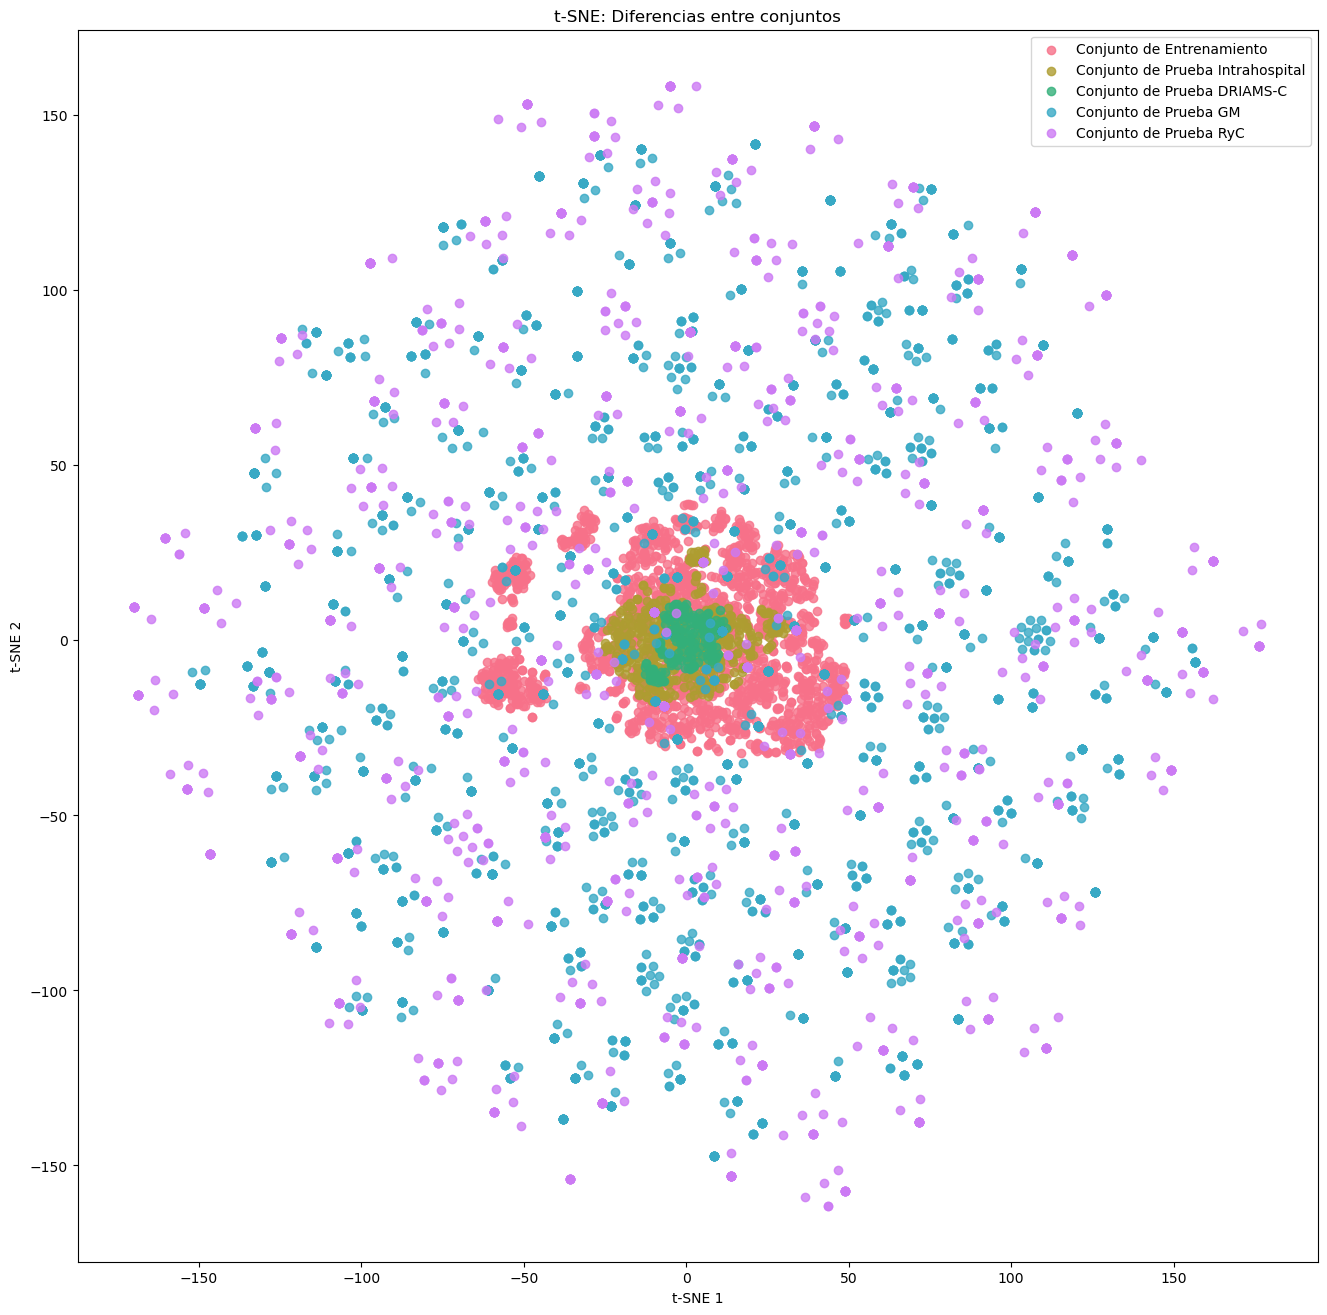

In [53]:
from sklearn.manifold import TSNE


titles = [
    'Conjunto de Entrenamiento',
    'Conjunto de Prueba Intrahospital',
    'Conjunto de Prueba DRIAMS-C',
    'Conjunto de Prueba GM',
    'Conjunto de Prueba RyC'
]

colors = sns.color_palette("husl", len(titles))

# Aplicar t-SNE al conjunto de entrenamiento
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(tensor_X_train)

# Transformar los conjuntos de prueba usando el mismo t-SNE
X_test_intrahospital_tsne = tsne.fit_transform(tensor_X_test_intrahospital.numpy())
X_test_driams_tsne = tsne.fit_transform(tensor_X_test_driams.numpy())
X_test_gm_tsne = tsne.fit_transform(tensor_X_test_gm.numpy())
X_test_ryc_tsne = tsne.fit_transform(tensor_X_test_ryc.numpy())

# Función para graficar con mejor selección de colores
def plot_tsne(datasets, titles, colors):
    plt.figure(figsize=(16, 16))
    
    for (X, y), title, color in zip(datasets, titles, colors):
        plt.scatter(X[:, 0], X[:, 1], c=[color], label=title, alpha=0.8)
    
    plt.title("t-SNE: Diferencias entre conjuntos")
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.show()

# Graficar conjuntos de datos con t-SNE
datasets_tsne = [
    (X_train_tsne, tensor_y_train),
    (X_test_intrahospital_tsne, tensor_y_test_intrahospital),
    (X_test_driams_tsne, tensor_y_test_driams),
    (X_test_gm_tsne, tensor_y_test_gm),
    (X_test_ryc_tsne, tensor_y_test_ryc)
]

# Graficar conjuntos de datos con t-SNE
plot_tsne(datasets_tsne, titles, colors)

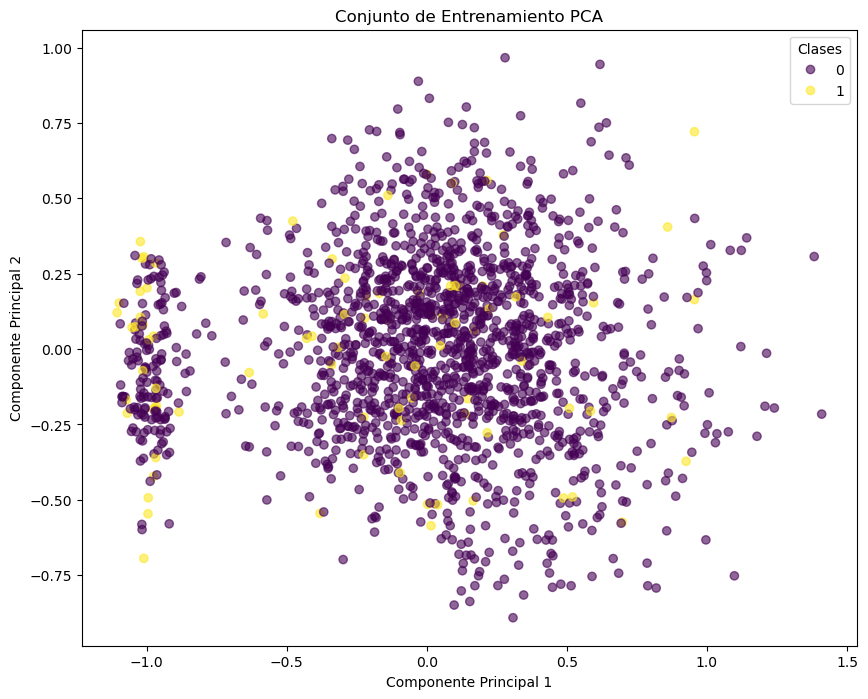

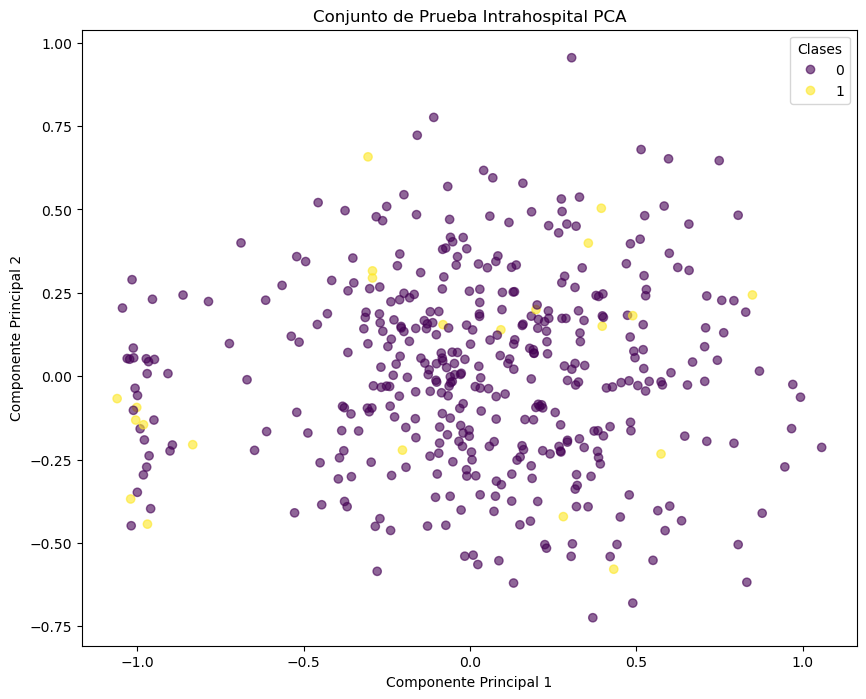

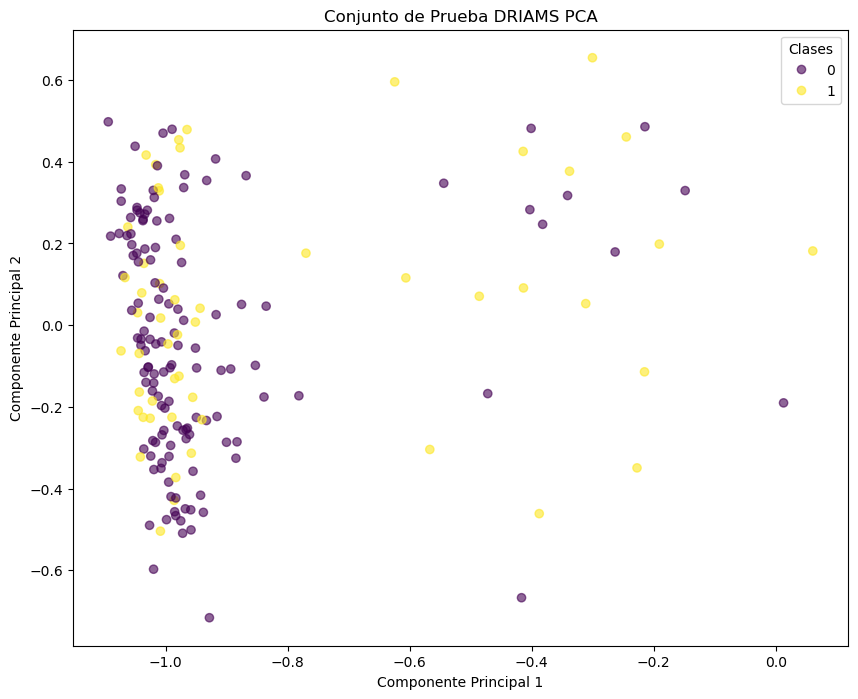

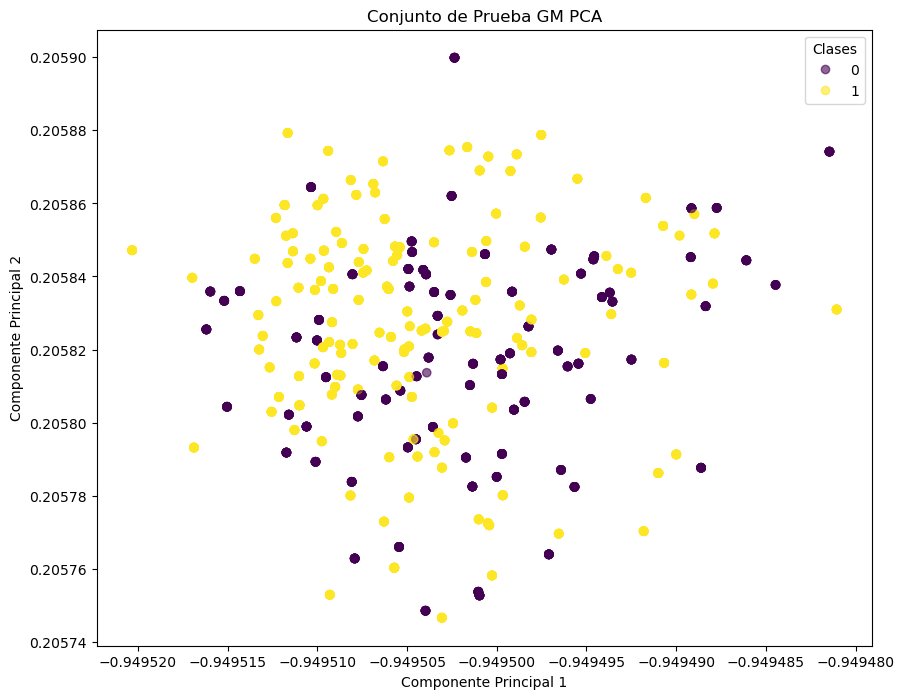

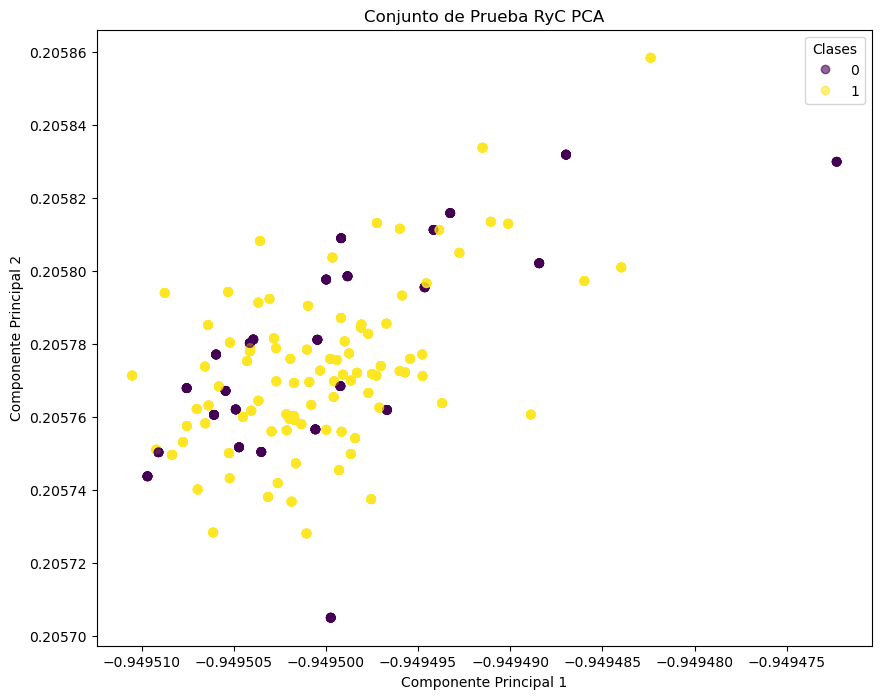

In [54]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(tensor_X_train)
X_test_intrahospital_pca = pca.transform(tensor_X_test_intrahospital)
X_test_driams_pca = pca.transform(tensor_X_test_driams)
X_test_gm_pca = pca.transform(tensor_X_test_gm)
X_test_ryc_pca = pca.transform(tensor_X_test_ryc)

def plot_pca(X, y, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
    plt.title(title)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend(*scatter.legend_elements(), title="Clases")
    plt.show()

# Graficar conjuntos de datos
plot_pca(X_train_pca, tensor_y_train, 'Conjunto de Entrenamiento PCA')
plot_pca(X_test_intrahospital_pca, tensor_y_test_intrahospital, 'Conjunto de Prueba Intrahospital PCA')
plot_pca(X_test_driams_pca, tensor_y_test_driams, 'Conjunto de Prueba DRIAMS PCA')
plot_pca(X_test_gm_pca, tensor_y_test_gm, 'Conjunto de Prueba GM PCA')
plot_pca(X_test_ryc_pca, tensor_y_test_ryc, 'Conjunto de Prueba RyC PCA')

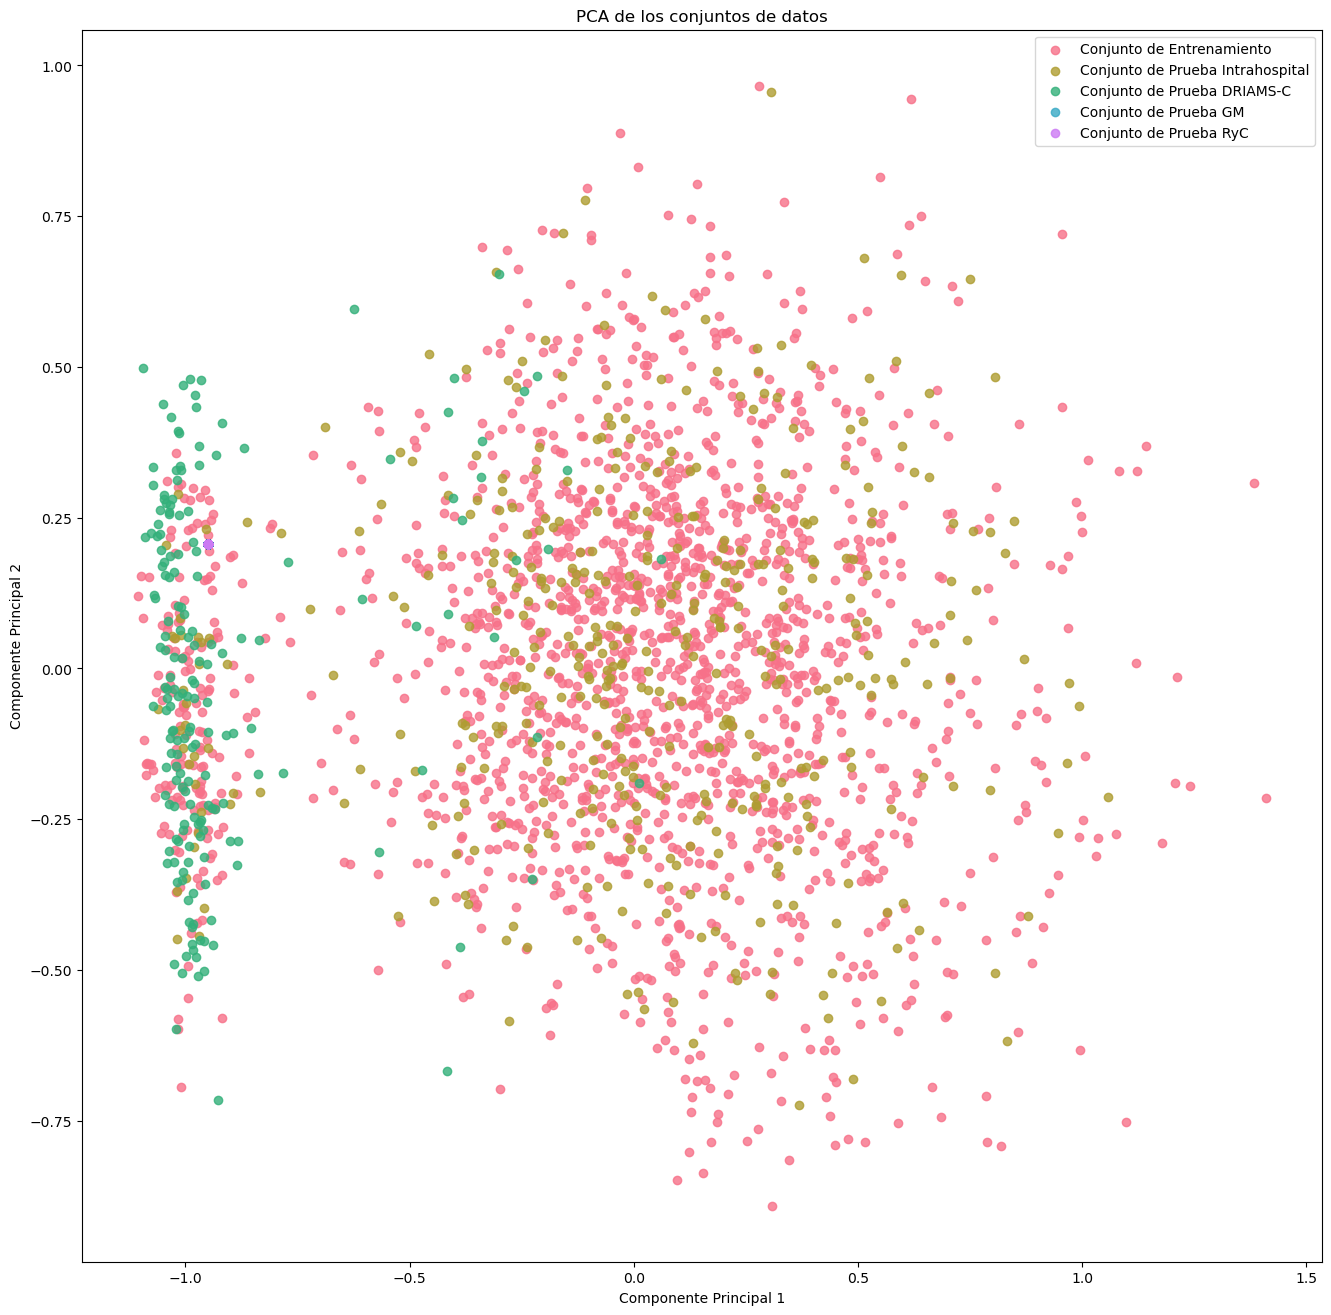

In [55]:
# Aplicar PCA con 4 componentes principales
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(tensor_X_train)

# Transformar los conjuntos de prueba usando el mismo PCA
X_test_intrahospital_pca = pca.transform(tensor_X_test_intrahospital.numpy())
X_test_driams_pca = pca.transform(tensor_X_test_driams.numpy())
X_test_gm_pca = pca.transform(tensor_X_test_gm.numpy())
X_test_ryc_pca = pca.transform(tensor_X_test_ryc.numpy())

# Función para graficar con mejor selección de colores
def plot_pca(datasets, titles, colors):
    plt.figure(figsize=(16, 16))
    
    for (X, y), title, color in zip(datasets, titles, colors):
        plt.scatter(X[:, 0], X[:, 1], c=[color], label=title, alpha=0.8)
    
    plt.title("PCA de los conjuntos de datos")
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.show()

# Graficar conjuntos de datos con el nuevo número de componentes principales
datasets = [
    (X_train_pca, tensor_y_train),
    (X_test_intrahospital_pca, tensor_y_test_intrahospital),
    (X_test_driams_pca, tensor_y_test_driams),
    (X_test_gm_pca, tensor_y_test_gm),
    (X_test_ryc_pca, tensor_y_test_ryc)
]

# Graficar conjuntos de datos con el nuevo número de componentes principales
plot_pca(datasets, titles, colors)

/tmp/ipykernel_9833/354143041.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8)


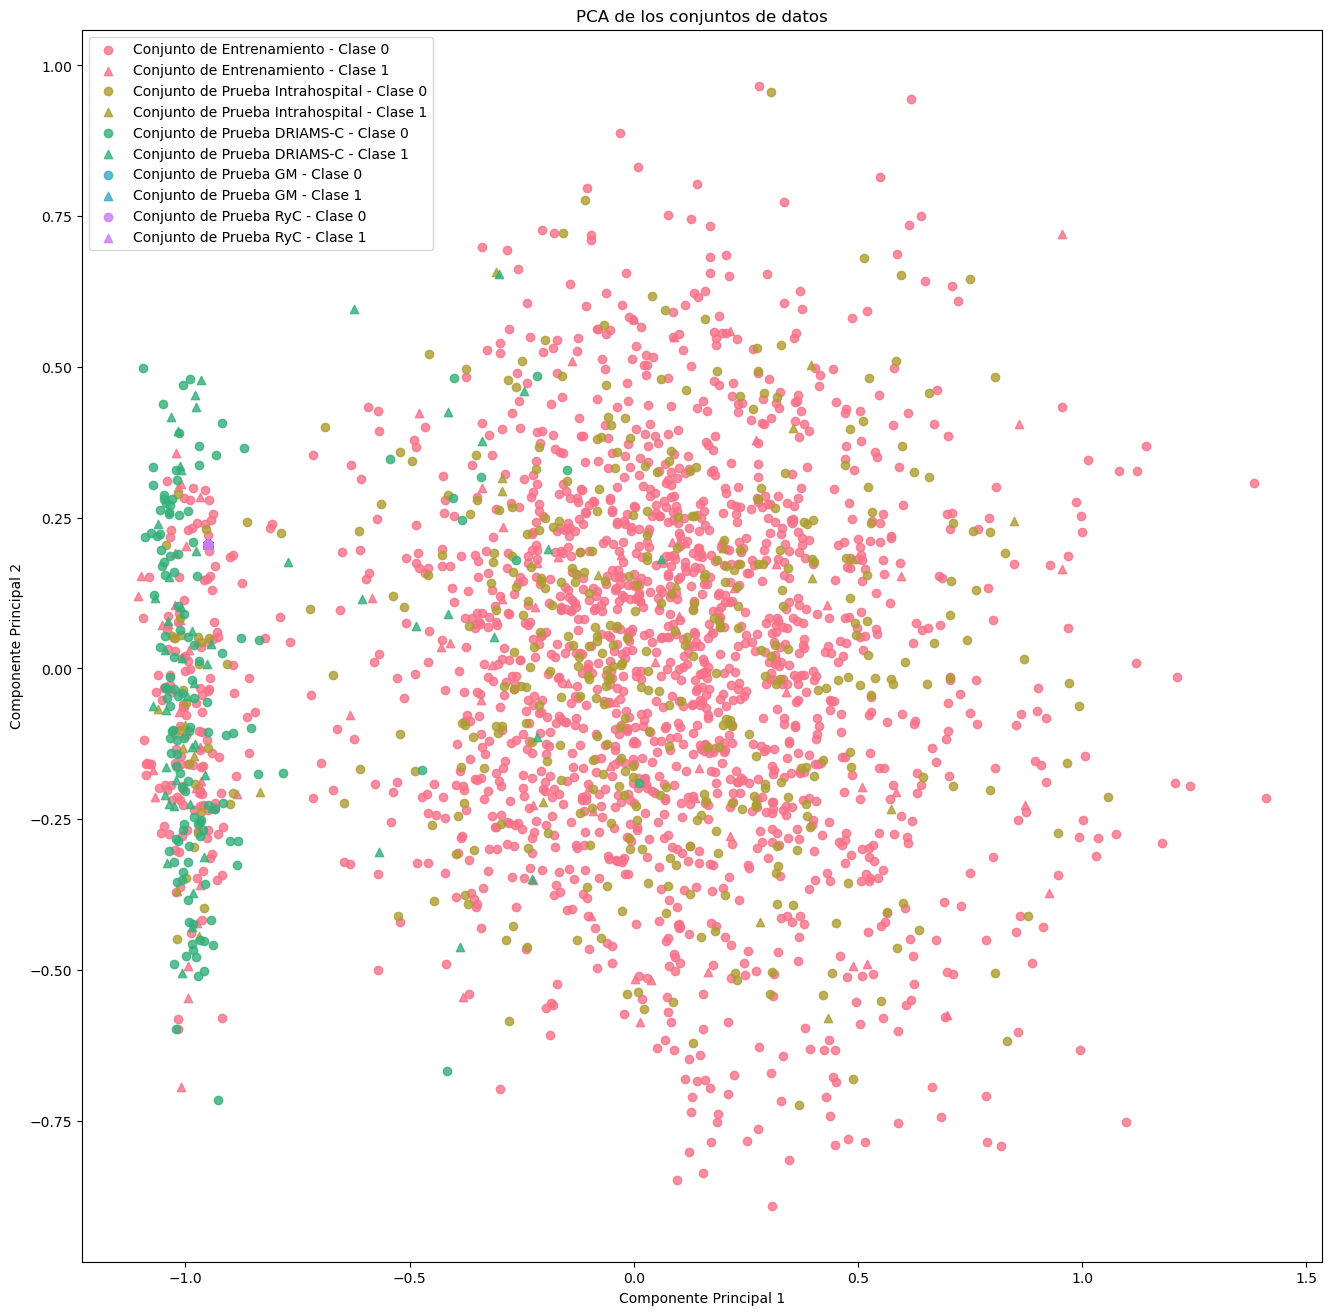

In [56]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Aplicar PCA con 4 componentes principales
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(tensor_X_train)

# Transformar los conjuntos de prueba usando el mismo PCA
X_test_intrahospital_pca = pca.transform(tensor_X_test_intrahospital.numpy())
X_test_driams_pca = pca.transform(tensor_X_test_driams.numpy())
X_test_gm_pca = pca.transform(tensor_X_test_gm.numpy())
X_test_ryc_pca = pca.transform(tensor_X_test_ryc.numpy())

# Función para graficar con mejor selección de colores y formas
def plot_pca(datasets, titles, colors):
    plt.figure(figsize=(16, 16))
    markers = ['o', '^']  # Definir marcadores para cada clase

    for (X, y), title, color in zip(datasets, titles, colors):
        for cls, marker in zip([0, 1], markers):  # Asignar marcadores a cada clase
            plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8)
    
    plt.title("PCA de los conjuntos de datos")
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.show()

# Graficar conjuntos de datos con el nuevo número de componentes principales
datasets = [
    (X_train_pca, tensor_y_train),
    (X_test_intrahospital_pca, tensor_y_test_intrahospital),
    (X_test_driams_pca, tensor_y_test_driams),
    (X_test_gm_pca, tensor_y_test_gm),
    (X_test_ryc_pca, tensor_y_test_ryc)
]

# Graficar conjuntos de datos con el nuevo número de componentes principales
plot_pca(datasets, titles, colors)


/tmp/ipykernel_9833/1328815230.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8)


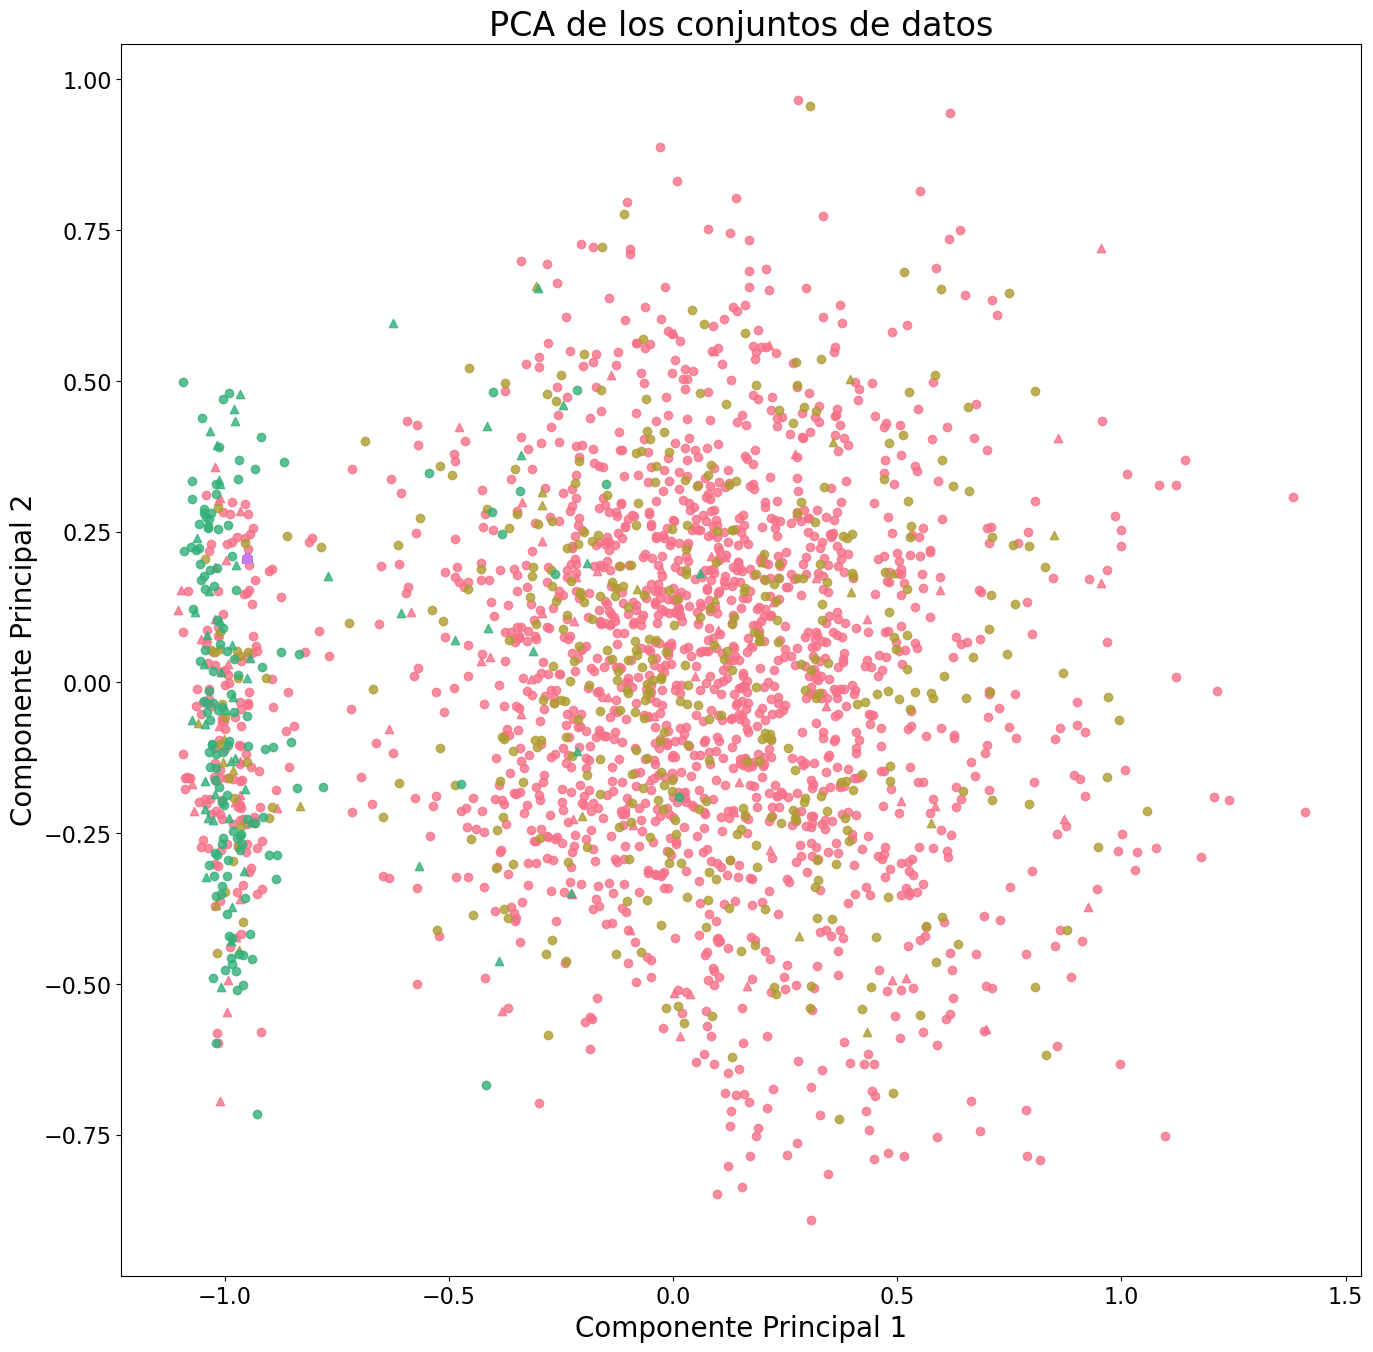

/tmp/ipykernel_9833/1328815230.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handle = ax.scatter([], [], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8, s=250)


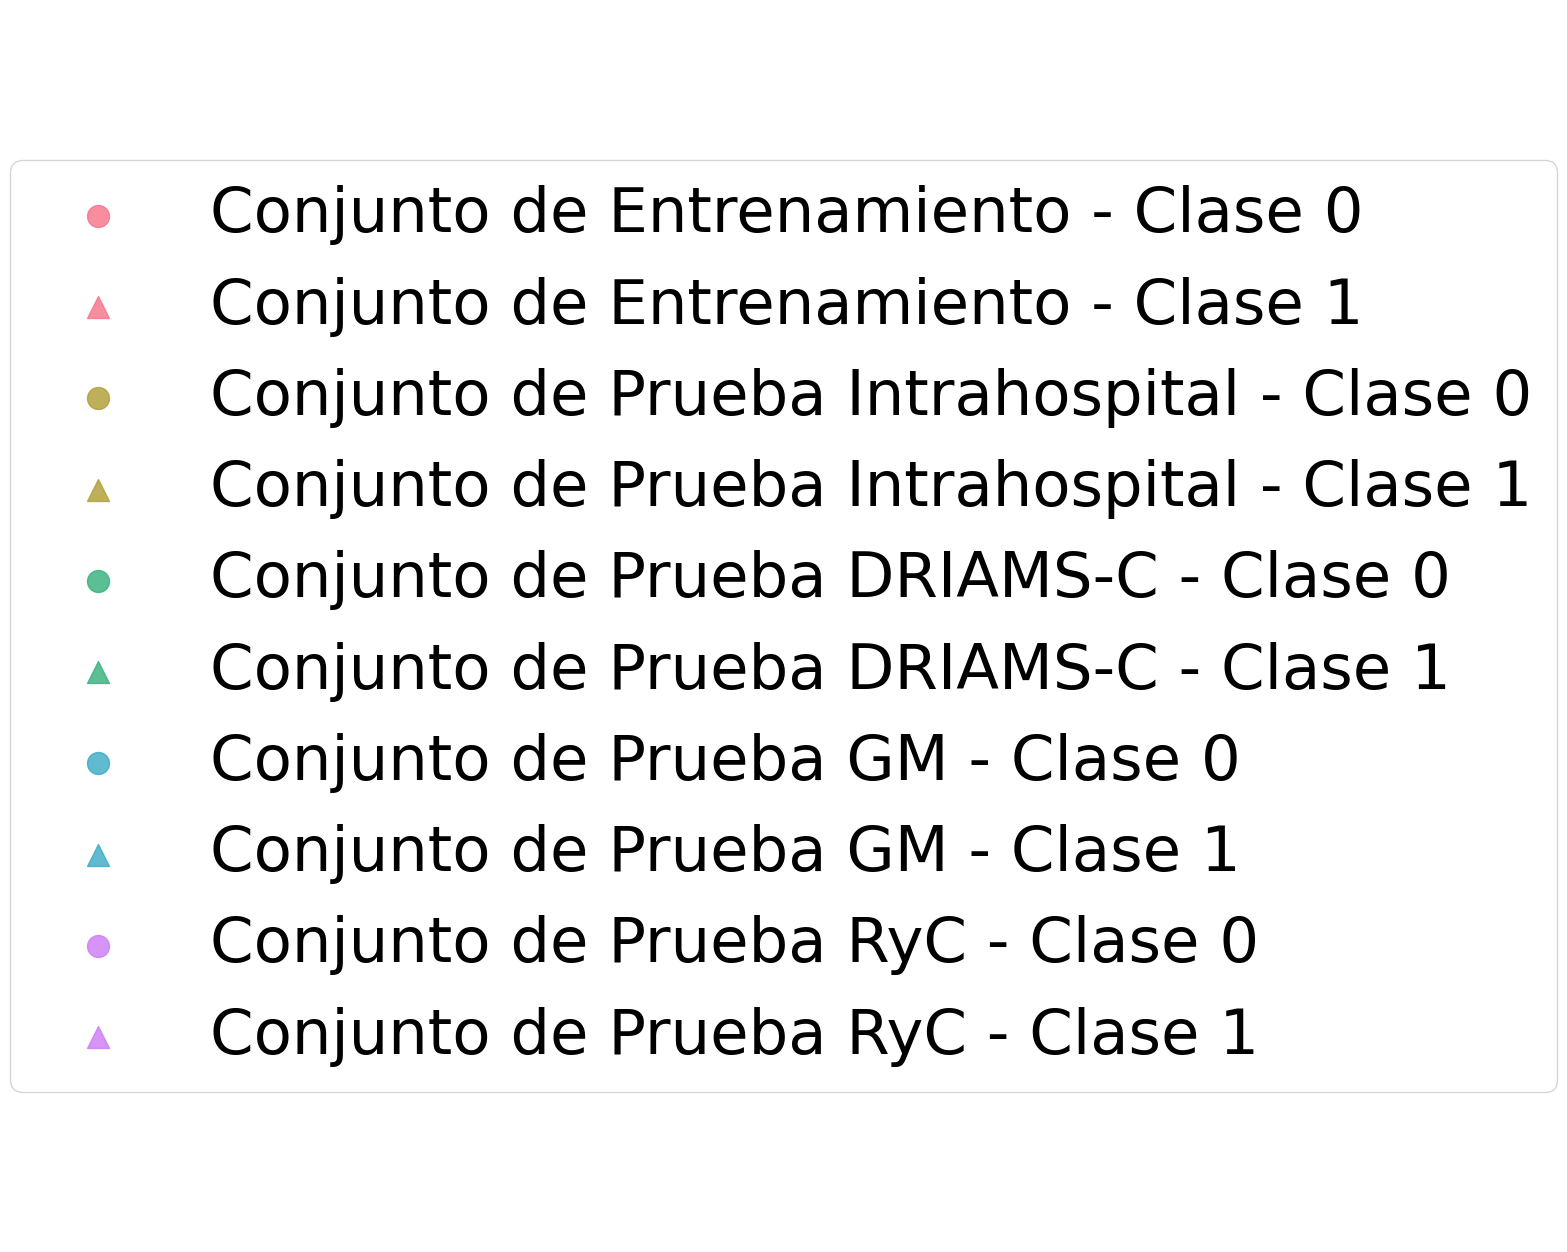

In [57]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Aplicar PCA con 4 componentes principales
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(tensor_X_train)

# Transformar los conjuntos de prueba usando el mismo PCA
X_test_intrahospital_pca = pca.transform(tensor_X_test_intrahospital.numpy())
X_test_driams_pca = pca.transform(tensor_X_test_driams.numpy())
X_test_gm_pca = pca.transform(tensor_X_test_gm.numpy())
X_test_ryc_pca = pca.transform(tensor_X_test_ryc.numpy())

# Función para graficar con mejor selección de colores y formas
def plot_pca(datasets, titles, colors):
    plt.figure(figsize=(16, 16))
    markers = ['o', '^']  # Definir marcadores para cada clase

    for (X, y), title, color in zip(datasets, titles, colors):
        for cls, marker in zip([0, 1], markers):  # Asignar marcadores a cada clase
            plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8)
    
    plt.title("PCA de los conjuntos de datos", fontsize=24)
    plt.xlabel('Componente Principal 1', fontsize=20)
    plt.ylabel('Componente Principal 2', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

# Función para graficar solo la leyenda en un plot separado
def plot_legend(datasets, titles, colors):
    fig, ax = plt.subplots(figsize=(16, 16))
    markers = ['o', '^']
    handles = []

    for (X, y), title, color in zip(datasets, titles, colors):
        for cls, marker in zip([0, 1], markers):
            handle = ax.scatter([], [], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8, s=250)
            handles.append(handle)
    
    legend = ax.legend(handles=handles, loc='center', fontsize=45)
    ax.axis('off')
    plt.show()

# Graficar conjuntos de datos con el nuevo número de componentes principales
datasets_pca = [
    (X_train_pca, tensor_y_train),
    (X_test_intrahospital_pca, tensor_y_test_intrahospital),
    (X_test_driams_pca, tensor_y_test_driams),
    (X_test_gm_pca, tensor_y_test_gm),
    (X_test_ryc_pca, tensor_y_test_ryc)
]

# Graficar conjuntos de datos y leyenda por separado
plot_pca(datasets_pca, titles, colors)
plot_legend(datasets_pca, titles, colors)


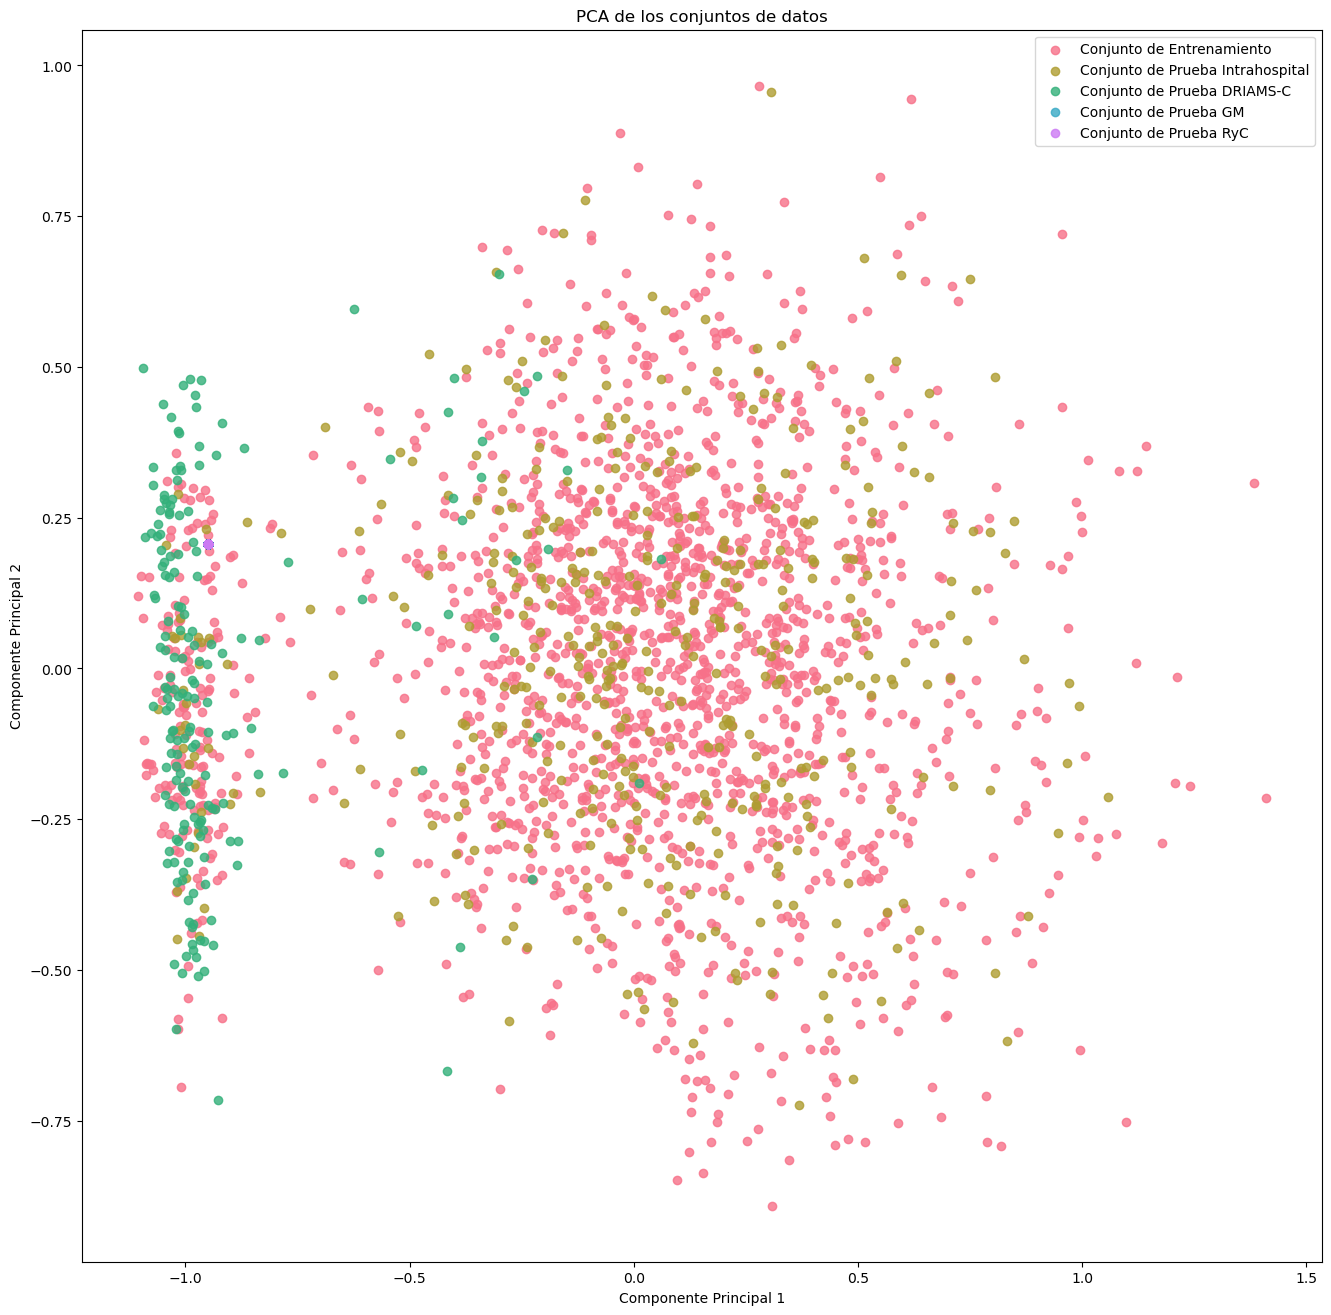

In [58]:
# Aplicar PCA con 4 componentes principales
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(tensor_X_train)

# Transformar los conjuntos de prueba usando el mismo PCA
X_test_intrahospital_pca = pca.transform(tensor_X_test_intrahospital.numpy())
X_test_driams_pca = pca.transform(tensor_X_test_driams.numpy())
X_test_gm_pca = pca.transform(tensor_X_test_gm.numpy())
X_test_ryc_pca = pca.transform(tensor_X_test_ryc.numpy())

# Función para graficar con mejor selección de colores
def plot_pca(datasets, titles, colors):
    plt.figure(figsize=(16, 16))
    
    for (X, y), title, color in zip(datasets, titles, colors):
        plt.scatter(X[:, 0], X[:, 1], c=[color], label=title, alpha=0.8)
    
    plt.title("PCA de los conjuntos de datos")
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.show()

# Graficar conjuntos de datos con el nuevo número de componentes principales
datasets = [
    (X_train_pca, tensor_y_train),
    (X_test_intrahospital_pca, tensor_y_test_intrahospital),
    (X_test_driams_pca, tensor_y_test_driams),
    (X_test_gm_pca, tensor_y_test_gm),
    (X_test_ryc_pca, tensor_y_test_ryc)
]

# Graficar conjuntos de datos con el nuevo número de componentes principales
plot_pca(datasets, titles, colors)

/tmp/ipykernel_9833/1013717846.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8)


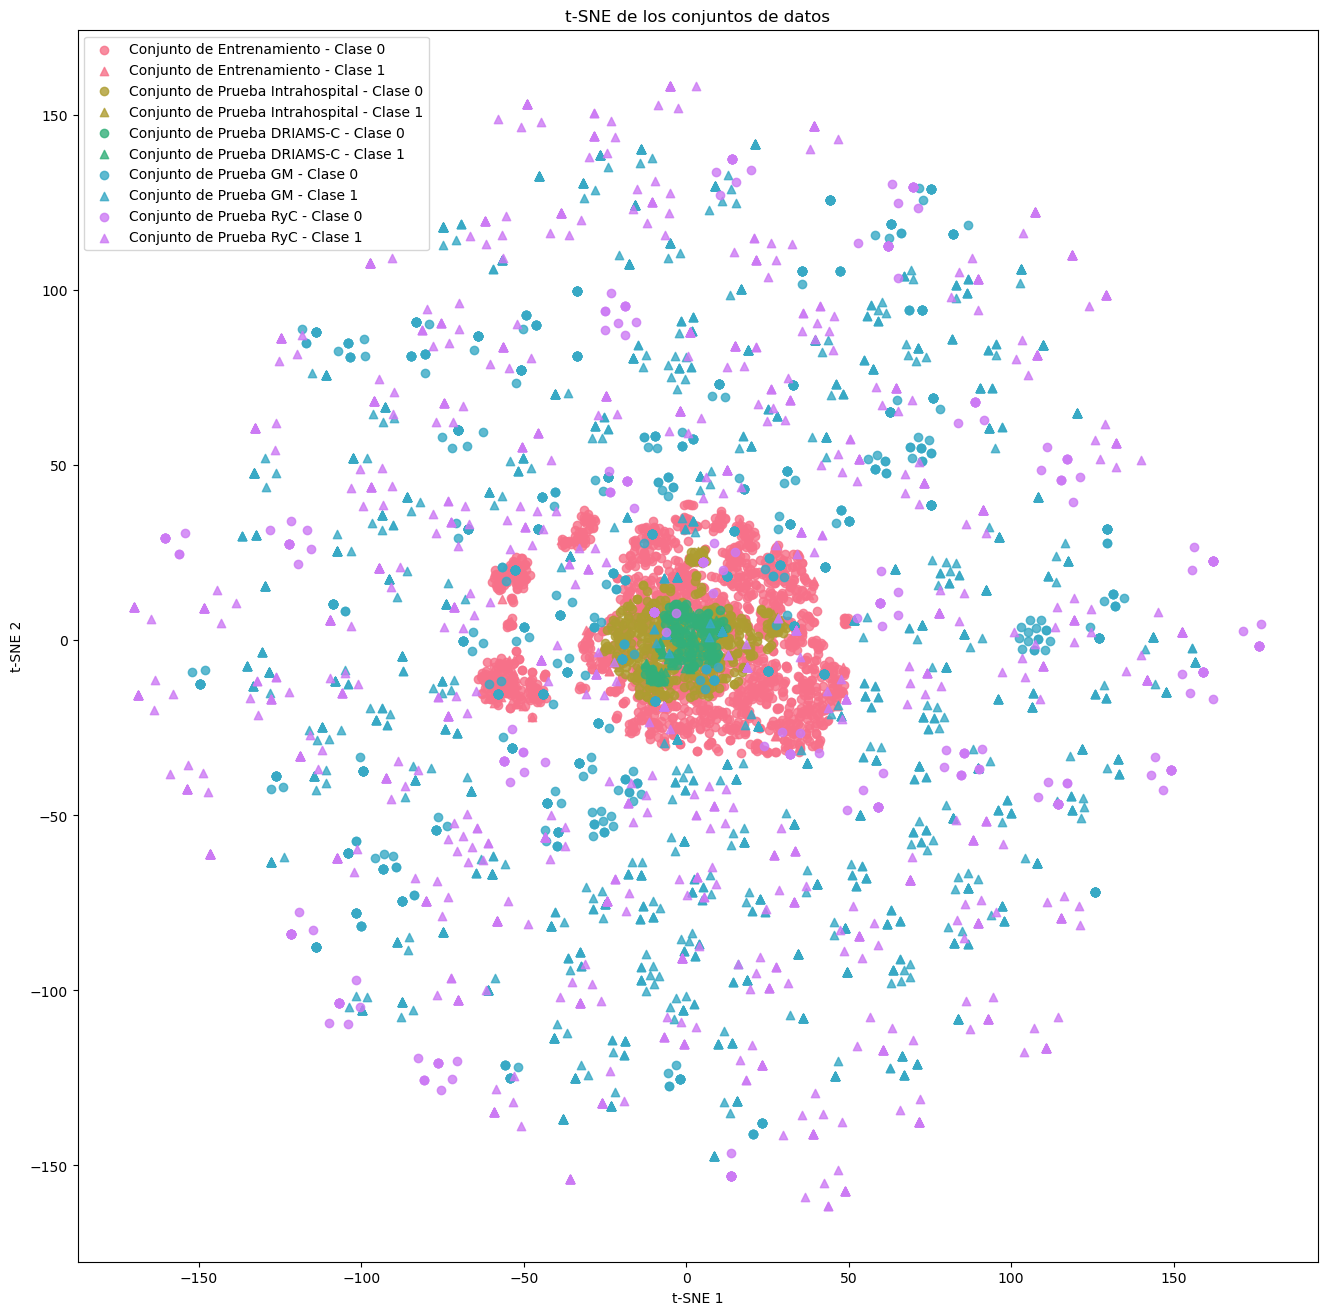

In [60]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Aplicar t-SNE al conjunto de entrenamiento
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(tensor_X_train)

# Transformar los conjuntos de prueba usando el mismo t-SNE
X_test_intrahospital_tsne = tsne.fit_transform(tensor_X_test_intrahospital.numpy())
X_test_driams_tsne = tsne.fit_transform(tensor_X_test_driams.numpy())
X_test_gm_tsne = tsne.fit_transform(tensor_X_test_gm.numpy())
X_test_ryc_tsne = tsne.fit_transform(tensor_X_test_ryc.numpy())

# Función para graficar con mejor selección de colores y formas
def plot_tsne(datasets, titles, colors):
    plt.figure(figsize=(16, 16))
    markers = ['o', '^', 's', 'x', 'D']  # Definir marcadores para cada conjunto de datos
    
    for i, ((X, y), title, color) in enumerate(zip(datasets, titles, colors)):
        for cls, marker in zip([0, 1], ['o', '^']):  # Asignar círculos a clase 0 y triángulos a clase 1
            plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8)
    
    plt.title("t-SNE de los conjuntos de datos")
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.show()

# Graficar conjuntos de datos con t-SNE
datasets_tsne = [
    (X_train_tsne, tensor_y_train),
    (X_test_intrahospital_tsne, tensor_y_test_intrahospital),
    (X_test_driams_tsne, tensor_y_test_driams),
    (X_test_gm_tsne, tensor_y_test_gm),
    (X_test_ryc_tsne, tensor_y_test_ryc)
]

# Graficar conjuntos de datos con t-SNE
plot_tsne(datasets_tsne, titles, colors)


/export/usuarios01/pscruz/miniconda3/envs/malditof/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


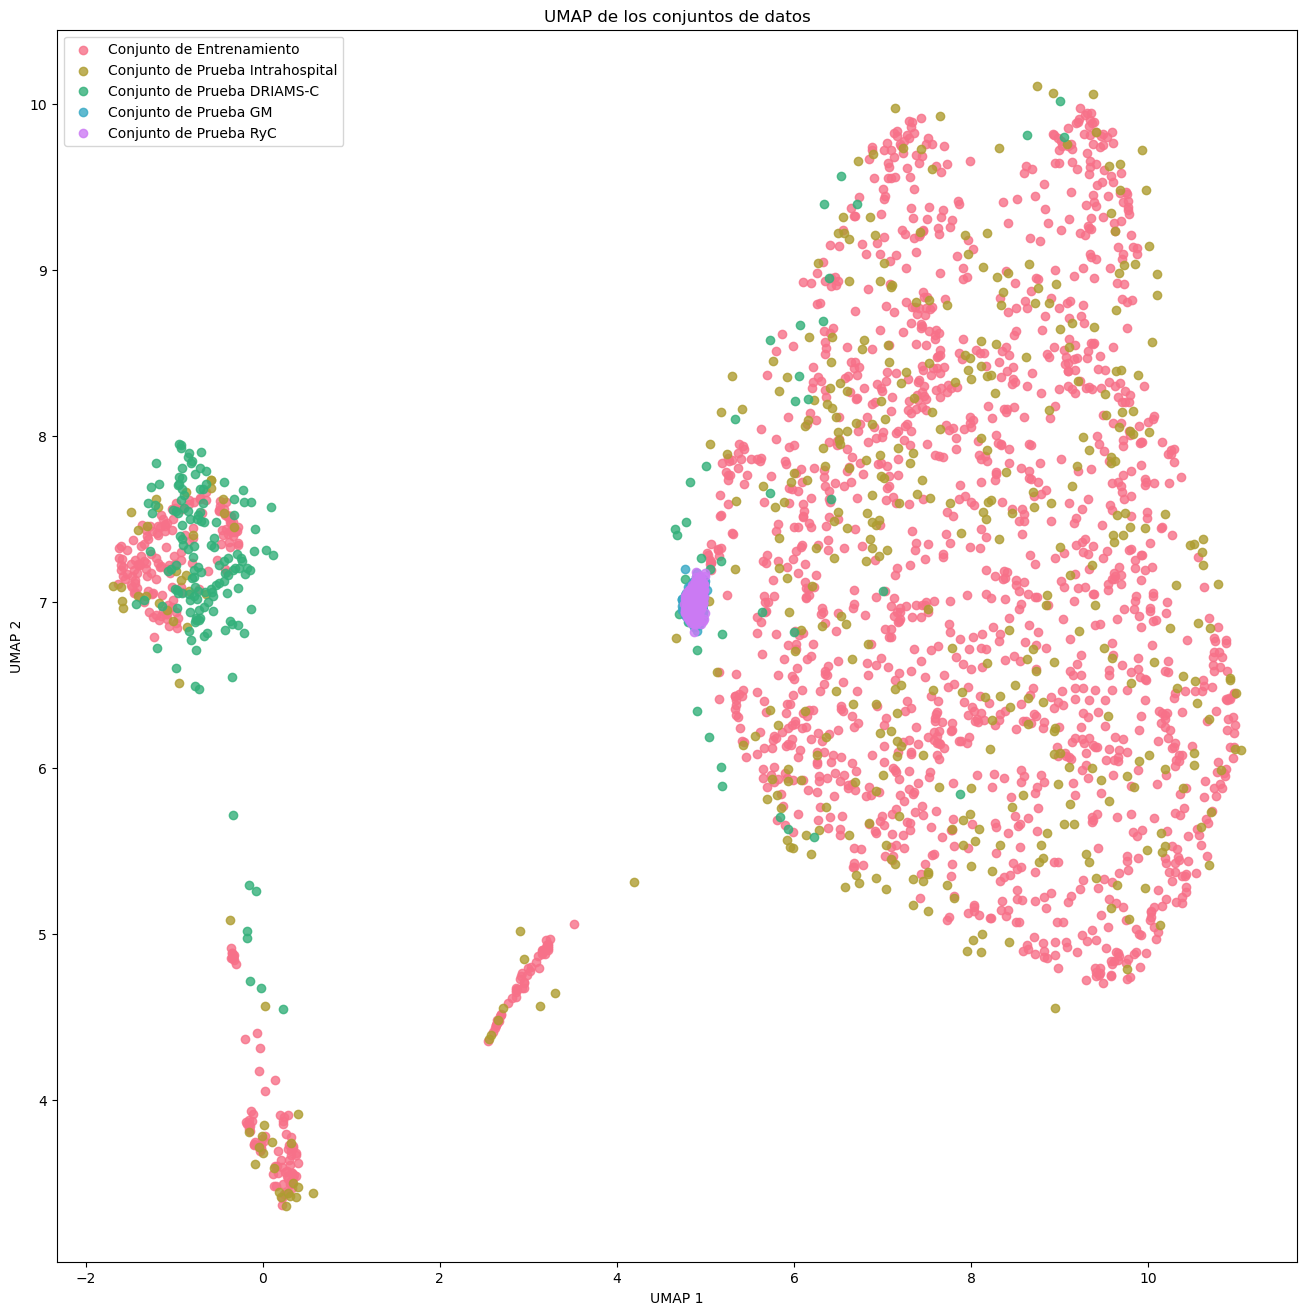

In [62]:
import umap

# Aplicar UMAP al conjunto de entrenamiento
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=50, min_dist=0.05)
X_train_umap = umap_model.fit_transform(tensor_X_train)

# Transformar los conjuntos de prueba usando el mismo UMAP
X_test_intrahospital_umap = umap_model.transform(tensor_X_test_intrahospital.numpy())
X_test_driams_umap = umap_model.transform(tensor_X_test_driams.numpy())
X_test_gm_umap = umap_model.transform(tensor_X_test_gm.numpy())
X_test_ryc_umap = umap_model.transform(tensor_X_test_ryc.numpy())

# Función para graficar con mejor selección de colores
def plot_umap(datasets, titles, colors):
    plt.figure(figsize=(16, 16))
    
    for (X, y), title, color in zip(datasets, titles, colors):
        plt.scatter(X[:, 0], X[:, 1], c=[color], label=title, alpha=0.8)
    
    plt.title("UMAP de los conjuntos de datos")
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.show()

# Graficar conjuntos de datos con UMAP
datasets_umap = [
    (X_train_umap, tensor_y_train),
    (X_test_intrahospital_umap, tensor_y_test_intrahospital),
    (X_test_driams_umap, tensor_y_test_driams),
    (X_test_gm_umap, tensor_y_test_gm),
    (X_test_ryc_umap, tensor_y_test_ryc)
]

# Graficar conjuntos de datos con UMAP
plot_umap(datasets_umap, titles, colors)

/tmp/ipykernel_9833/3316910090.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8)


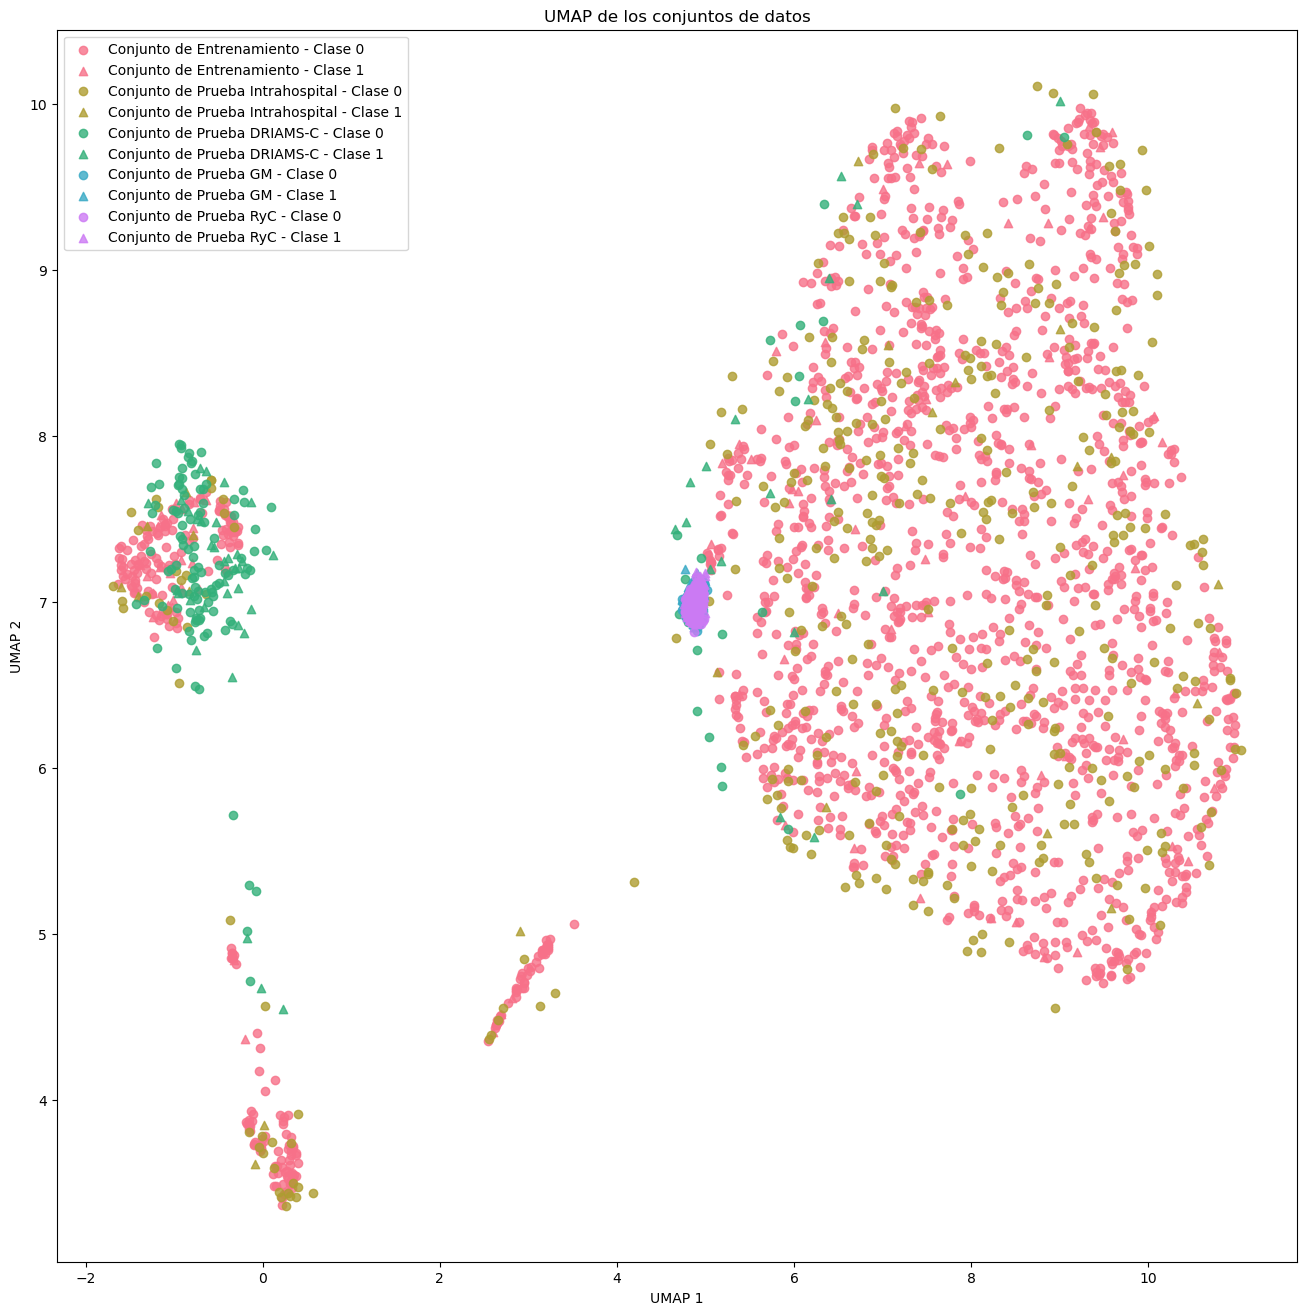

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Función para graficar con mejor selección de colores y formas
def plot_umap(datasets, titles, colors):
    plt.figure(figsize=(16, 16))
    markers = ['o', '^', 's', 'x', 'D']  # Definir marcadores para cada conjunto de datos
    
    for i, ((X, y), title, color) in enumerate(zip(datasets, titles, colors)):
        for cls, marker in zip([0, 1], ['o', '^']):  # Asignar círculos a clase 0 y triángulos a clase 1
            plt.scatter(X[y == cls, 0], X[y == cls, 1], c=color, label=f"{title} - Clase {cls}", marker=marker, alpha=0.8)
    
    plt.title("UMAP de los conjuntos de datos")
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.show()

# Graficar conjuntos de datos con UMAP
plot_umap(datasets_umap, titles, colors)

